# 0. Imports

## 0.0. Imports

In [130]:
import re
import warnings
import datetime

import numpy   as np
import pandas  as pd
import seaborn as sns

import umap.umap_ as umap

from sklearn.manifold._t_sne    import TSNE
from pandas_profiling      import ProfileReport
from matplotlib            import pyplot as plt
from IPython.display       import HTML
from yellowbrick.cluster   import KElbowVisualizer
from yellowbrick.cluster   import SilhouetteVisualizer
 
from sklearn               import cluster as c
from sklearn               import metrics as m
from plotly                import express as px
from matplotlib            import pyplot  as plt
from sklearn               import decomposition as dd
from sklearn               import preprocessing as pp
from sklearn               import ensemble as en

## 0.1. Helper Functions 

In [39]:
warnings.filterwarnings("ignore")

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [14, 7]
    plt.rcParams['font.size'] = 24
    
    sns.set
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Load Dataset

In [40]:
# load data
df_raw = pd.read_csv('C:/Users/joaoh/repos/Insiders-Clustering/data/Ecommerce.csv', encoding='unicode_escape')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# 1. Data Description

In [41]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [42]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data Dimensions

In [43]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3.  Data Types

In [44]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [45]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [46]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [47]:
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

## 1.6. Change Types

In [48]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int64)

In [49]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [50]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [51]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1. Numerical Attributes - Investigating

1. Negative Quantity (Refund?)
2. Unit Price equals Zero (Promo?)

### 1.7.2 Categorical Attributes

In [52]:
cat_attributes

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom
...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,France


#### Invoice Number

#### Stock Code

In [53]:
# check stock_code only characters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

# Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [54]:
# ====== Nothing ======

#### Country

In [55]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [56]:
df1['country'].value_counts(normalize=True)

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 2.0. Features Filtering

In [57]:
df2 = df1.copy()

In [58]:
# unit price > 0.0
df2 = df2.loc[df2['unit_price'] > 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
                                   'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchases = df2.loc[df2['quantity'] > 0, :]

# 3. Feature Engineering

In [59]:
df3 = df2.copy()

df3_returns = df2_returns
df3_purchases = df2_purchases

In [60]:
# Feature Ideas:

## Moving Average - 7d, 14d, 30d.
## Quantidade de Compras por mês, antes do dia 15 e depois do dia 15.

## 3.1. Feature Creation

In [61]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [62]:
# Gross Revenue
df3_purchases['gross_revenue'] = df3_purchases['quantity'] * df3_purchases['unit_price']

# Monetary
df_monetary = df3_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

### 3.1.2. Recency - Last Day Purchase

In [63]:
# Recency - Last Day Purchase
df_recency = df3_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()       
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### 3.1.3. Quantity of Purchased

In [64]:
# Number of Products
df_quantity = (df3_purchases.loc[:,['customer_id', 'invoice_no']].drop_duplicates()
                                                                .groupby('customer_id')
                                                                .count()
                                                                .reset_index()
                                                                .rename(columns={'invoice_no':'qtde_invoices'}))
               
df_ref = pd.merge(df_ref, df_quantity, on='customer_id', how='left')

### 3.1.4. Quantity of Items Purchased

In [65]:
# Quantity of Products Purchased
df_freq = (df3_purchases.loc[:,['customer_id', 'quantity']].groupby('customer_id')
                                                          .sum()
                                                          .reset_index()
                                                          .rename(columns={'quantity':'qtde_items'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.4. Quantity of Products Purchased

In [66]:
# Quantity of Items Purchased
df_freq = (df3_purchases.loc[:,['customer_id', 'stock_code']].groupby('customer_id').count()
                                                             .reset_index()
                                                             .rename(columns={'stock_code':'qtde_products'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

### 3.1.5. Average Ticket Value

In [67]:
# Avg Ticket
df_avg_ticket = df3_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

### 3.1.6. Average Recency Days

In [68]:
# Avg Recency Days
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=True)
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

# drop NA
df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average rececency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
#df_avg_recency_days['avg_recency_days'] = df_avg_recency_days['avg_recency_days'].astype(str)
#df_avg_recency_days['avg_recency_days'] = df_avg_recency_days['avg_recency_days'].apply(lambda x: str(re.search("^.+s", x).group(0)))

df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')

### 3.1.7. Frequency Purchase

In [69]:
df_aux = ( df3_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                              .groupby('customer_id')
                                                              .agg(max_ = ('invoice_date', 'max'),
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_= ('invoice_date', lambda x: (x.max() - x.min()).days),
                                                                   buy_ = ('invoice_no', 'count'))).reset_index()


df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [70]:
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8. Number of Returns

In [71]:
df_returns = df3_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size (Quantity)

In [72]:
df_aux = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                               .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                    n_products=('quantity', 'sum'))
                                                                               .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_items            91
qtde_products         91
avg_ticket            91
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.2.0. Unique Basket Size

In [73]:
df_aux = (df3_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                               .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                    n_products=('stock_code', 'nunique'))
                                                                               .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_items                  91
qtde_products               91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

### Final Ref

In [74]:
df_ref

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,34.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028391,35.0,154.444444,11.666667
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040431,50.0,335.200000,7.600000
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017986,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.075000,22.0,26.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
5782,22706,5699.00,1.0,1.0,1747.0,634.0,8.988959,NaN,0.000000,0.0,1747.000000,634.000000
5783,22707,6756.06,0.0,1.0,2010.0,730.0,9.254877,NaN,0.000000,0.0,2010.000000,730.000000
5784,22708,3217.20,0.0,1.0,654.0,59.0,54.528814,NaN,0.000000,0.0,654.000000,56.000000
5785,22709,3950.72,0.0,1.0,731.0,217.0,18.206083,NaN,0.000000,0.0,731.000000,217.000000


# 4. Exploratory Data Analysis

In [75]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariated Analysis

**Notes**
1. Clusters Coesos - Separados
2. Métricas
    - Min, Máximo, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância
    - Coeficiente de Variação
    - Distribuição
   

In [76]:
profile = ProfileReport(df4)
profile.to_file('output_v1.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


### 4.4.1 Gross Revenue

In [77]:
df4[df4['gross_revenue'] >= 279138.02]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203966,288.0,2733.944444,9.708333


### 4.4.2. Quantity of Items

In [78]:
df3[df3['customer_id'] == 14646]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646
...,...,...,...,...,...,...,...
534958,581176,22908,96,2017-12-05,0.72,Netherlands,14646
534959,581176,22907,96,2017-12-05,0.72,Netherlands,14646
534960,581176,22029,72,2017-12-05,0.36,Netherlands,14646
534961,581176,22712,72,2017-12-05,0.36,Netherlands,14646


In [79]:
df4[df4['qtde_products'] == 7837]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
68,17841,40959.72,1.0,124.0,22853.0,7837.0,5.226454,3.321429,0.333333,203.0,184.298387,10.653226


### 4.4.3. Average Ticket

In [80]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3338,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009756,80995.0,40498.5,1.5


In [81]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


In [82]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203966,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163488,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.128134,952.0,1521.586957,2.695652
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009756,80995.0,40498.500000,1.500000
66,14911,140438.72,1.0,199.0,79963.0,5670.0,24.768734,2.601399,0.534946,3332.0,401.824121,8.969849


In [83]:
df3[df3['customer_id'] == 14646]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646
...,...,...,...,...,...,...,...
534958,581176,22908,96,2017-12-05,0.72,Netherlands,14646
534959,581176,22907,96,2017-12-05,0.72,Netherlands,14646
534960,581176,22029,72,2017-12-05,0.36,Netherlands,14646
534961,581176,22712,72,2017-12-05,0.36,Netherlands,14646


In [84]:
np.sum(df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'])

278778.02

In [85]:
df3.loc[df3['customer_id'] == 14646, 'quantity'].sum()

196556

## 4.2. Bivariated Analysis

In [86]:
cols = ['customer_id']
df4_aux = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

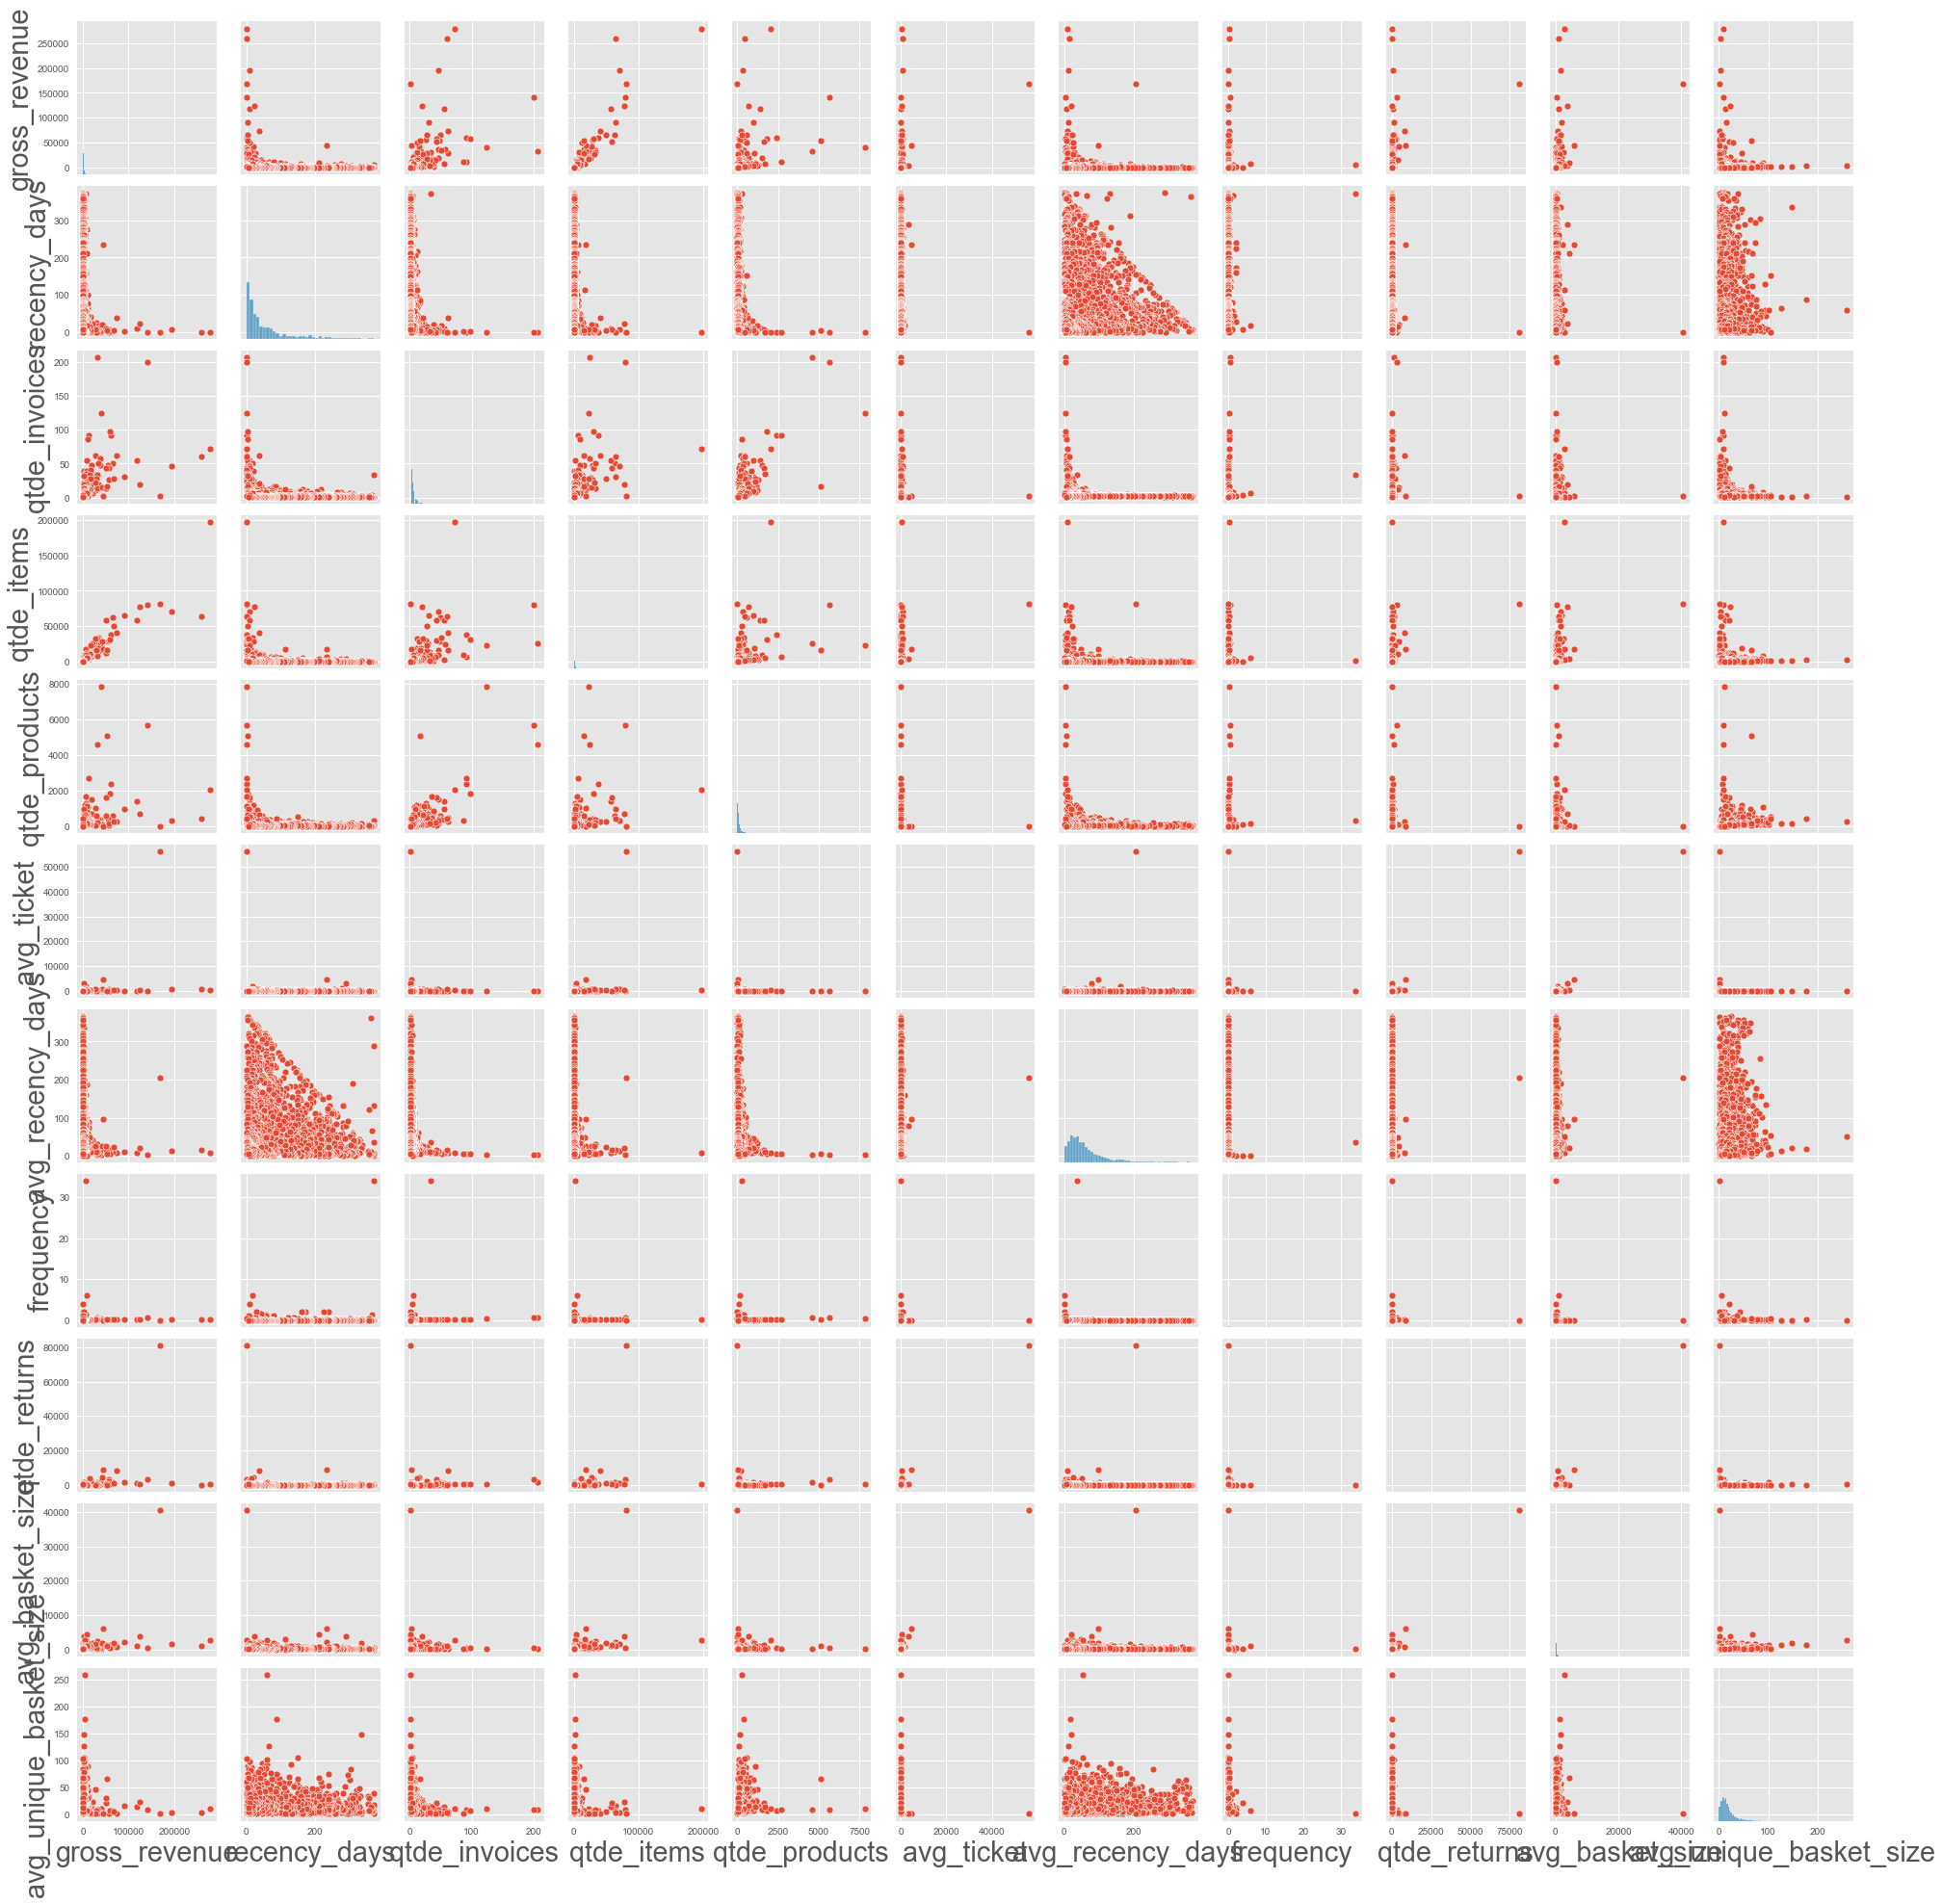

In [87]:
plt.figure(figsize=(25, 12))
sns.pairplot(df4_aux)

## 4.3. Estudo do Espaço

In [101]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [102]:
mm = pp.MinMaxScaler()

#
df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
df43['qtde_invoices']          = mm.fit_transform(df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform(df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform(df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1. PCA

In [ ]:
X.shape[1]

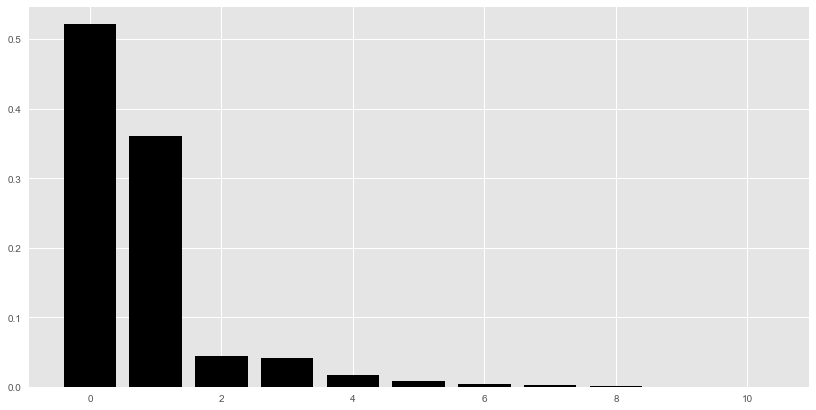

In [109]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

<AxesSubplot:xlabel='0', ylabel='1'>

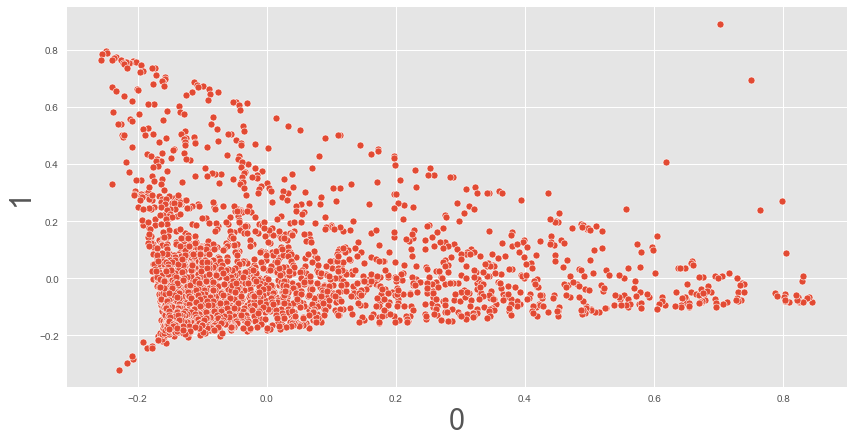

In [111]:
sns.scatterplot(x=0, y=1, data=df_pca)

### 4.3.2. UMAP

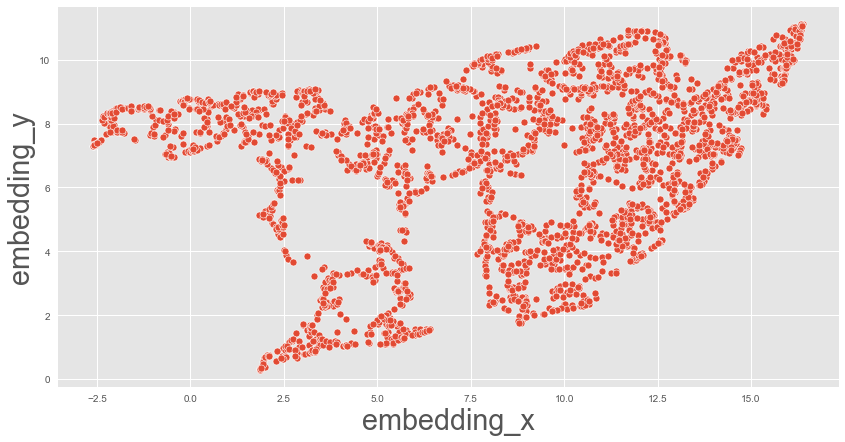

In [112]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y', 
                data=df_pca);

### 4.3.3. t-SNE

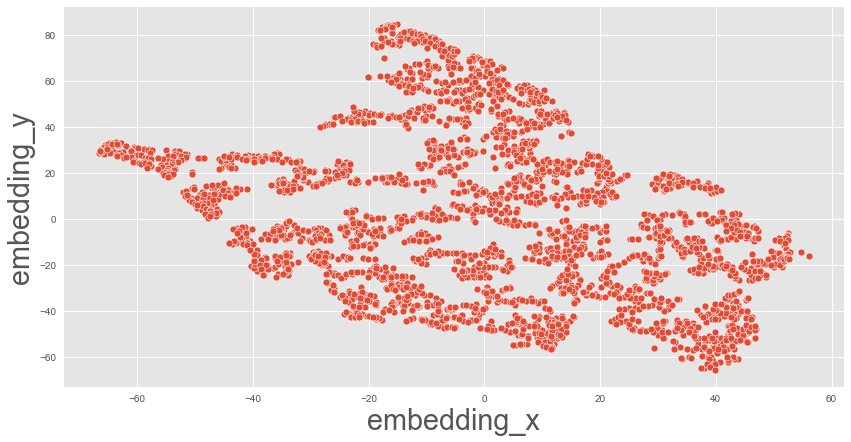

In [125]:
reducer = TSNE(n_components=2,
               n_jobs=-1,
               random_state=42)

embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y', 
                data=df_pca);

### 4.3.4. Tree-Based Embedding

In [132]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf


# dataframe Leaf

RandomForestRegressor(random_state=42)

In [133]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [134]:
df_leaf.shape

(2969, 100)

In [135]:
X.shape

(2969, 10)

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

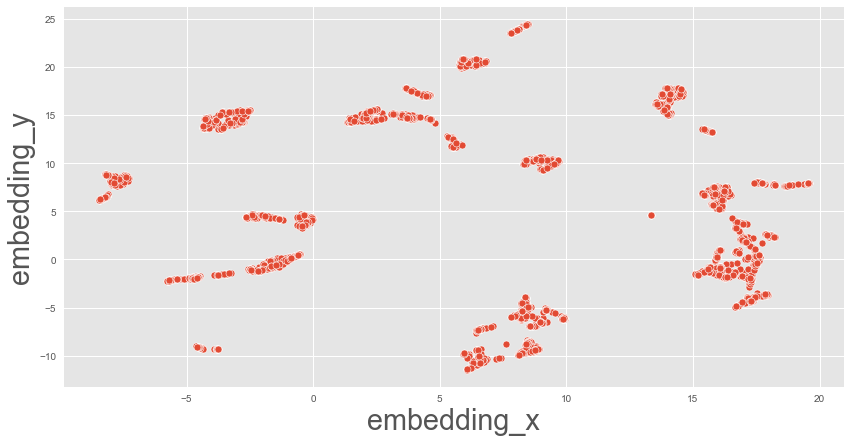

In [138]:
# Reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                data=df_pca)

# PAREI AQUI

# 5. Data Preparation

In [ ]:
df5 = df4.copy()

In [ ]:
# Standard Scaler
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

# 6. Feature Selection

In [ ]:
df6 = df5.copy()

# 7. Hyperparameter Fine-Tuning

In [ ]:
df7 = df6.drop(columns=['customer_id'])

In [ ]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum of Square (WSS)

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(df7)
kmeans.show();

## 7.2. Silhouette Score

In [ ]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(df7);
kmeans.show();

### 7.2.1. Silhouette Analysis

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df7);
    visualizer.finalize()

# 8. Model Training

In [ ]:
df8 = df7.copy()

## 8.1. K-Means

In [ ]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(df8)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [ ]:
## WSS ( Within-Cluster Sum of Square)
print('WSS Value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score)
print('Silhouette Score: {}'.format(m.silhouette_score(df8, labels, metric='euclidean')))

# 9. Cluster Analysis

In [ ]:
df9 = df6.copy()
df9['cluster'] = labels

In [ ]:
df9

## 9.1. Visualization Inspection

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df8)
visualizer.finalize()

## 9.2. 2D Plot

In [ ]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP - t-SNE

In [ ]:
reducer = umap.UMAP(n_neighbors=50, random_state=42)
embedding = reducer.fit_transform(df8)

# embedding
df9['embedding_x'] = embedding[:, 0]
df9['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster',
                palette=sns.color_palette('hls', n_colors=len(df9['cluster'].unique())),
                data=df9);

## 9.2. Cluster Profile

In [ ]:
# Number of Customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Average Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Average Recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Average Invoice Number
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# Average Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

### Cluster 01: Insiders Candidate
    - Number of Customers: 6 (0.14%)
    - Avg Recency: 7 days.
    - Avg Purchases: 89 purchases.
    - Avg Revenue: $182,182.98 dollars.

### Cluster 02:
    - Number of Customers: 14 (0.13%)
    - Avg Recency: 13 days.
    - Avg Purchases: 53 purchases.
    - Avg Revenue: $40,543.51 dollars.
    
### Cluster 03: 
    - Number of Customers: 4335 (99,15%)
    - Avg Recency: 92 days.
    - Avg Purchases: 4 purchases.
    - Avg Revenue: $1,372.57 dollars.

# 10. Deploy To Production